<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/beras_rendah1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [3]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [4]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [5]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fe5be504fa0>)

In [6]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [7]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [8]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.beras_kualitas_bawah_i.values
date = dataset.index

## Train test val split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


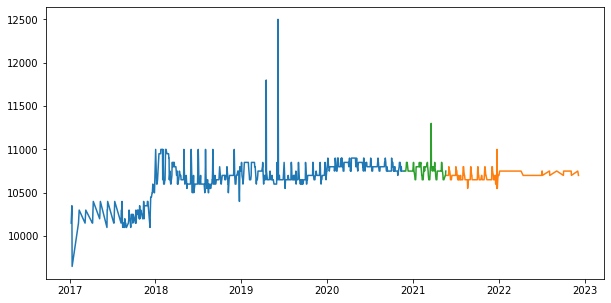

In [10]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [13]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [14]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_beras_rendah1_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [ ]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [ ]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 23s 359ms/step - loss: 0.1571 - mae: 0.3951 - mape: 97.0439 - val_loss: 0.0139 - val_mae: 0.1022 - val_mape: 9784485.0000
Epoch 2/30
44/44 [==============================] - 8s 182ms/step - loss: 0.1011 - mae: 0.3166 - mape: 77.7323 - val_loss: 0.0078 - val_mae: 0.0732 - val_mape: 19282116.0000
Epoch 3/30
44/44 [==============================] - 8s 185ms/step - loss: 0.0648 - mae: 0.2534 - mape: 62.1902 - val_loss: 0.0075 - val_mae: 0.0601 - val_mape: 26475180.0000
Epoch 4/30
44/44 [==============================] - 8s 185ms/step - loss: 0.0429 - mae: 0.2059 - mape: 50.4940 - val_loss: 0.0104 - val_mae: 0.0820 - val_mape: 32734416.0000
Epoch 5/30
44/44 [==============================] - 8s 181ms/step - loss: 0.0287 - mae: 0.1680 - mape: 41.1737 - val_loss: 0.0151 - val_mae: 0.1016 - val_mape: 37969856.0000
Epoch 6/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0191 - mae: 0.1367 - mape: 33.4759 - val_loss: 0.0206 

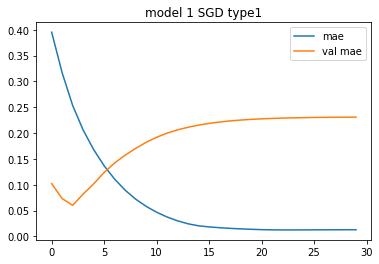

In [ ]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 22ms/step
96.12213 0.900295 107.14987039918667


,date,actual,prediction
0,2021-05-20,10700,10803.149414
1,2021-05-21,10700,10802.956055
2,2021-05-24,10700,10802.467773
3,2021-05-25,10700,10802.057617
4,2021-05-27,10700,10801.502930
...,...,...,...
229,2022-11-02,10750,10795.720703
230,2022-11-03,10750,10796.014648
231,2022-11-04,10700,10796.188477
232,2022-12-01,10750,10796.496094


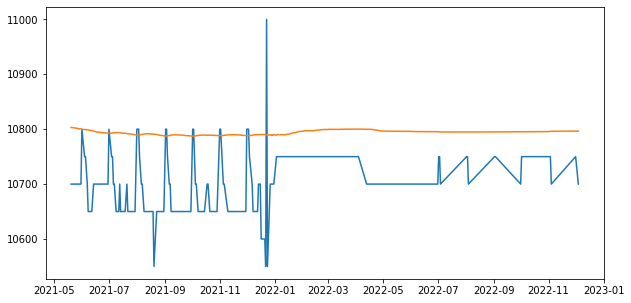

In [ ]:
prediction = forecast_predict(model, test_beras_rendah1_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_beras_rendah1 = pd.DataFrame()
data_new_beras_rendah1['date'] = y_test
data_new_beras_rendah1['actual'] = x_test
data_new_beras_rendah1['prediction'] = data_result
data_new_beras_rendah1.to_csv('beras_rendah1_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_beras_rendah1.date, data_new_beras_rendah1.actual)
plt.plot(data_new_beras_rendah1.date, data_new_beras_rendah1.prediction)
data_new_beras_rendah1

#### type2

In [ ]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0309 - mape: 8.0680 - val_loss: 0.0553 - val_mae: 0.2194 - val_mape: 59103660.0000
Epoch 2/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0298 - mape: 7.6815 - val_loss: 0.0554 - val_mae: 0.2198 - val_mape: 59166948.0000
Epoch 3/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0294 - mape: 7.5818 - val_loss: 0.0557 - val_mae: 0.2204 - val_mape: 59267308.0000
Epoch 4/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0297 - mape: 7.6778 - val_loss: 0.0554 - val_mae: 0.2196 - val_mape: 59137696.0000
Epoch 5/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0291 - mape: 7.4892 - val_loss: 0.0561 - val_mae: 0.2213 - val_mape: 59411960.0000
Epoch 6/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0295 - mape: 7.6064 - val_loss: 0

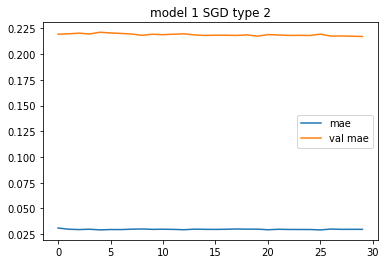

In [ ]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
67.618996 0.6335133 80.53689468963898


,date,actual,prediction
0,2021-05-20,10700,10803.149414
1,2021-05-21,10700,10802.956055
2,2021-05-24,10700,10802.467773
3,2021-05-25,10700,10802.057617
4,2021-05-27,10700,10801.502930
...,...,...,...
229,2022-11-02,10750,10795.720703
230,2022-11-03,10750,10796.014648
231,2022-11-04,10700,10796.188477
232,2022-12-01,10750,10796.496094


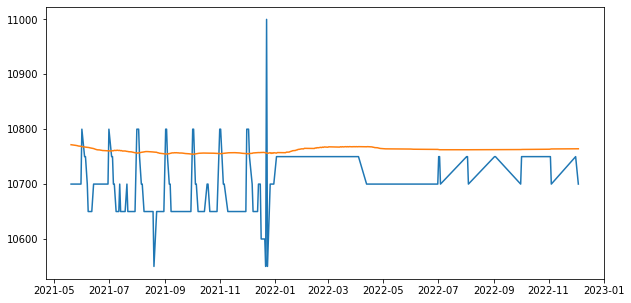

In [ ]:
win_size1 = 60
test_beras_rendah1_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_beras_rendah1_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_beras_rendah1_1 = pd.DataFrame()
data_new_beras_rendah1_1['actual'] = x_test
data_new_beras_rendah1_1['prediction'] = data_result_1
data_new_beras_rendah1_1.to_csv('beras_rendah1_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah1_1.actual)
plt.plot(y_test, data_new_beras_rendah1_1.prediction)
data_new_beras_rendah1

#### type3

In [ ]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 13s 149ms/step - loss: 0.0020 - mae: 0.0251 - mape: 6.2745 - val_loss: 0.0526 - val_mae: 0.2133 - val_mape: 58134564.0000
Epoch 2/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0020 - mae: 0.0250 - mape: 6.2322 - val_loss: 0.0524 - val_mae: 0.2127 - val_mape: 58041960.0000
Epoch 3/30
84/84 [==============================] - 12s 146ms/step - loss: 0.0020 - mae: 0.0251 - mape: 6.2595 - val_loss: 0.0527 - val_mae: 0.2135 - val_mape: 58162376.0000
Epoch 4/30
84/84 [==============================] - 12s 140ms/step - loss: 0.0020 - mae: 0.0251 - mape: 6.2567 - val_loss: 0.0526 - val_mae: 0.2132 - val_mape: 58109580.0000
Epoch 5/30
84/84 [==============================] - 11s 129ms/step - loss: 0.0020 - mae: 0.0251 - mape: 6.2404 - val_loss: 0.0525 - val_mae: 0.2130 - val_mape: 58086772.0000
Epoch 6/30
84/84 [==============================] - 11s 130ms/step - loss: 0.0020 - mae: 0.0251 - mape: 6.2605 - val_loss: 0.0527 

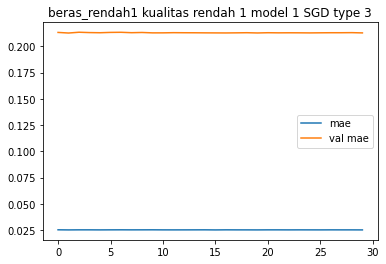

In [ ]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('beras_rendah1 kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
57.622063 0.5399197 71.991095098196


,actual,prediction
0,10700,10759.957031
1,10700,10759.747070
2,10700,10759.232422
3,10700,10758.798828
4,10700,10758.201172
...,...,...
229,10750,10751.635742
230,10750,10751.930664
231,10700,10752.145508
232,10750,10752.451172


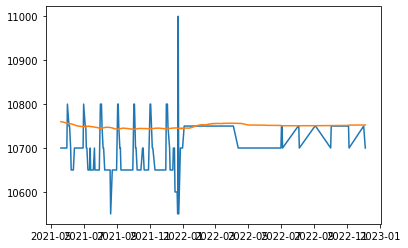

In [ ]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_beras_rendah1_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_beras_rendah1_2 = pd.DataFrame()
# data_new_beras_rendah11['date'] = date_test
data_new_beras_rendah1_2['actual'] = x_test
data_new_beras_rendah1_2['prediction'] = data_result_2
data_new_beras_rendah1_2.to_csv('beras_rendah1_model1_sgd_type3')

plt.plot(y_test, data_new_beras_rendah1_2.actual)
plt.plot(y_test, data_new_beras_rendah1_2.prediction)
data_new_beras_rendah1_2

### Adam

In [ ]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [ ]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 13s 207ms/step - loss: 0.1186 - mae: 0.3420 - mape: 83.9676 - val_loss: 0.0096 - val_mae: 0.0841 - val_mape: 15399393.0000
Epoch 2/30
44/44 [==============================] - 8s 189ms/step - loss: 0.0362 - mae: 0.1794 - mape: 43.9392 - val_loss: 0.0167 - val_mae: 0.1090 - val_mape: 39515388.0000
Epoch 3/30
44/44 [==============================] - 8s 188ms/step - loss: 9.7067e-04 - mae: 0.0249 - mape: 6.1219 - val_loss: 0.0263 - val_mae: 0.1429 - val_mape: 46081728.0000
Epoch 4/30
44/44 [==============================] - 8s 189ms/step - loss: 3.0197e-04 - mae: 0.0141 - mape: 3.4473 - val_loss: 0.0266 - val_mae: 0.1440 - val_mape: 46293636.0000
Epoch 5/30
44/44 [==============================] - 8s 187ms/step - loss: 2.8472e-04 - mae: 0.0141 - mape: 3.4423 - val_loss: 0.0266 - val_mae: 0.1438 - val_mape: 46256460.0000
Epoch 6/30
44/44 [==============================] - 9s 212ms/step - loss: 2.7798e-04 - mae: 0.0138 - mape: 3.3870 - val_

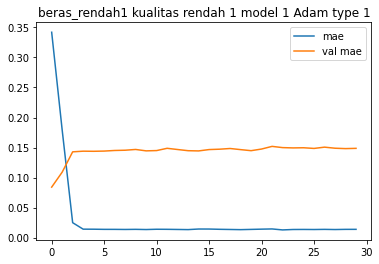

In [ ]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('beras_rendah1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
59.755444 0.5595951 71.53302818344649


,actual,prediction
0,10700,10785.333008
1,10700,10786.166992
2,10700,10783.561523
3,10700,10784.338867
4,10700,10781.212891
...,...,...
229,10750,10758.817383
230,10750,10759.694336
231,10700,10759.524414
232,10750,10760.581055


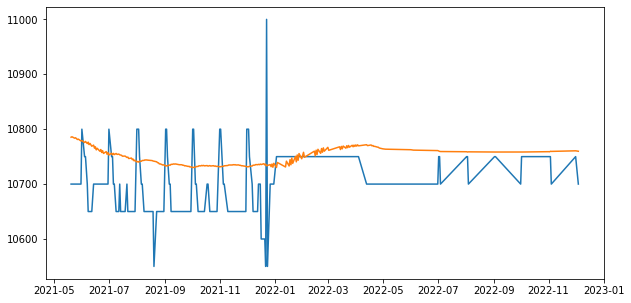

In [ ]:
prediction_a = forecast_predict(model_a, test_beras_rendah1_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_beras_rendah1_a = pd.DataFrame()
# data_new_beras_rendah11['date'] = date_test
data_new_beras_rendah1_a['actual'] = x_test
data_new_beras_rendah1_a['prediction'] = data_result_a
data_new_beras_rendah1_a.to_csv('beras_rendah1_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_beras_rendah1_a.actual)
plt.plot(y_test, data_new_beras_rendah1_a.prediction)
data_new_beras_rendah1_a

#### Type 2

In [ ]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0273 - mape: 6.9495 - val_loss: 0.0305 - val_mae: 0.1552 - val_mape: 48534388.0000
Epoch 2/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0269 - mape: 6.8620 - val_loss: 0.0324 - val_mae: 0.1603 - val_mape: 49542376.0000
Epoch 3/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0020 - mae: 0.0273 - mape: 6.9807 - val_loss: 0.0322 - val_mae: 0.1598 - val_mape: 49476752.0000
Epoch 4/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0019 - mae: 0.0263 - mape: 6.7020 - val_loss: 0.0345 - val_mae: 0.1660 - val_mape: 50618700.0000
Epoch 5/30
718/718 [==============================] - 24s 34ms/step - loss: 0.0019 - mae: 0.0263 - mape: 6.7160 - val_loss: 0.0374 - val_mae: 0.1737 - val_mape: 52051044.0000
Epoch 6/30
718/718 [==============================] - 25s 34ms/step - loss: 0.0019 - mae: 0.0262 - mape: 6.6874 - val_loss: 0

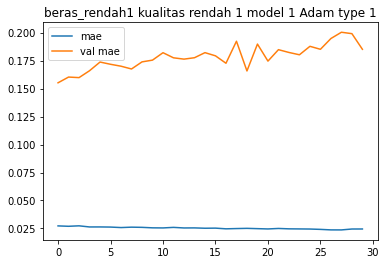

In [ ]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('beras_rendah1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
58.835896 0.5508873 69.84131008042446


,actual,prediction
0,10700,10783.909180
1,10700,10786.180664
2,10700,10780.395508
3,10700,10782.729492
4,10700,10776.494141
...,...,...
229,10750,10755.229492
230,10750,10757.939453
231,10700,10757.023438
232,10750,10759.877930


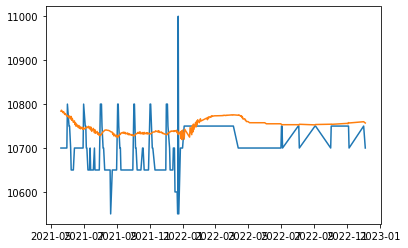

In [ ]:
prediction_a1 = forecast_predict(model_a, test_beras_rendah1_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_beras_rendah1_a1 = pd.DataFrame()
data_new_beras_rendah1_a1['actual'] = x_test
data_new_beras_rendah1_a1['prediction'] = data_result_a1
data_new_beras_rendah1_a1.to_csv('beras_rendah1_model1_adam_type2.csv')

plt.plot(y_test, data_new_beras_rendah1_a1.actual)
plt.plot(y_test, data_new_beras_rendah1_a1.prediction)
data_new_beras_rendah1_a1

#### Type 3

In [ ]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0018 - mae: 0.0199 - mape: 4.8655 - val_loss: 0.0407 - val_mae: 0.1823 - val_mape: 53591968.0000
Epoch 2/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0018 - mae: 0.0196 - mape: 4.7785 - val_loss: 0.0400 - val_mae: 0.1804 - val_mape: 53289300.0000
Epoch 3/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0018 - mae: 0.0198 - mape: 4.8563 - val_loss: 0.0380 - val_mae: 0.1750 - val_mape: 52341136.0000
Epoch 4/30
84/84 [==============================] - 11s 126ms/step - loss: 0.0018 - mae: 0.0196 - mape: 4.7835 - val_loss: 0.0372 - val_mae: 0.1731 - val_mape: 52000496.0000
Epoch 5/30
84/84 [==============================] - 11s 126ms/step - loss: 0.0018 - mae: 0.0192 - mape: 4.6322 - val_loss: 0.0373 - val_mae: 0.1732 - val_mape: 52027252.0000
Epoch 6/30
84/84 [==============================] - 11s 124ms/step - loss: 0.0018 - mae: 0.0203 - mape: 4.9834 - val_loss: 0.0361 

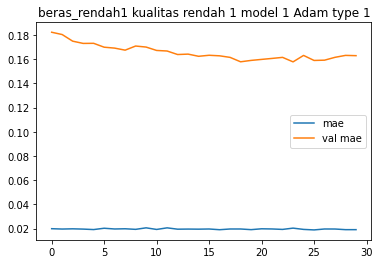

In [ ]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('beras_rendah1 kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
58.714615 0.5494919 69.07508722963186


,actual,prediction
0,10700,10801.046875
1,10700,10803.036133
2,10700,10797.159180
3,10700,10799.327148
4,10700,10792.769531
...,...,...
229,10750,10763.322266
230,10750,10766.500977
231,10700,10764.781250
232,10750,10768.166016


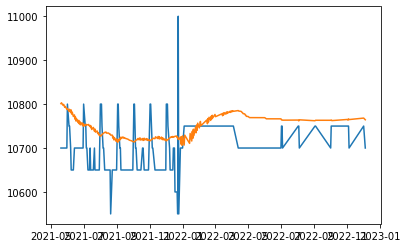

In [ ]:
prediction_a2 = forecast_predict(model_a, test_beras_rendah1_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_beras_rendah1_a2 = pd.DataFrame()
# data_new_beras_rendah11['date'] = date_test
data_new_beras_rendah1_a2['actual'] = x_test
data_new_beras_rendah1_a2['prediction'] = data_result_a2
data_new_beras_rendah1_a2.to_csv('beras_rendah1_model1_adam_type3.csv')

plt.plot(y_test, data_new_beras_rendah1_a2.actual)
plt.plot(y_test, data_new_beras_rendah1_a2.prediction)
data_new_beras_rendah1_a2

## model 1

### Adam

In [11]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          96        
                                                                 
 lstm (LSTM)                 (None, None, 128)         74240     
                                                                 
 lstm_1 (LSTM)               (None, 32)                20608     
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-trai

#### Type 1

In [ ]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 18s 331ms/step - loss: 0.1220 - mae: 0.3452 - mape: 84.7317 - val_loss: 0.0077 - val_mae: 0.0711 - val_mape: 19787634.0000
Epoch 2/15
44/44 [==============================] - 14s 310ms/step - loss: 0.0080 - mae: 0.0644 - mape: 15.6184 - val_loss: 0.0203 - val_mae: 0.1230 - val_mape: 42024184.0000
Epoch 3/15
44/44 [==============================] - 14s 311ms/step - loss: 3.1661e-04 - mae: 0.0143 - mape: 3.5194 - val_loss: 0.0198 - val_mae: 0.1209 - val_mape: 41622488.0000
Epoch 4/15
44/44 [==============================] - 14s 314ms/step - loss: 3.2881e-04 - mae: 0.0152 - mape: 3.7249 - val_loss: 0.0201 - val_mae: 0.1221 - val_mape: 41848168.0000
Epoch 5/15
44/44 [==============================] - 14s 313ms/step - loss: 3.1359e-04 - mae: 0.0147 - mape: 3.5827 - val_loss: 0.0195 - val_mae: 0.1200 - val_mape: 41445016.0000
Epoch 6/15
44/44 [==============================] - 14s 311ms/step - loss: 3.2839e-04 - mae: 0.0153 - mape: 3.7526 -

17/17 [==============================] - 0s 16ms/step - loss: 0.0048 - mae: 0.0647 - mape: 15.9193


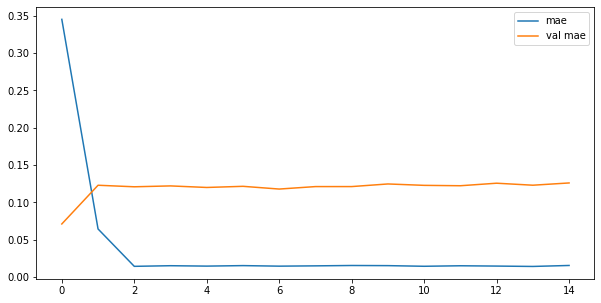

In [ ]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction1 = forecast_predict(model1, test_beras_rendah1_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_beras_rendah11 = pd.DataFrame()
data_new_beras_rendah11['actual'] = x_test
data_new_beras_rendah11['prediction'] = data_result1
data_new_beras_rendah11.to_csv('beras_rendah1_model2_adam_type1.csv')

data_new_beras_rendah11

131/131 [==============================] - 5s 33ms/step
201.34572 1.884092 207.5408562940078


,actual,prediction
0,10700,10910.238281
1,10700,10910.154297
2,10700,10910.052734
3,10700,10909.928711
4,10700,10909.786133
...,...,...
229,10750,10902.783203
230,10750,10902.834961
231,10700,10902.826172
232,10750,10902.889648


In [ ]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_beras_rendah11['actual'], '-o')
plt.plot(range(len(x_test)), data_new_beras_rendah11['prediction'], '-o')

#### Type 2

In [15]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 38s 47ms/step - loss: 0.0079 - mae: 0.0466 - mape: 12.1288 - val_loss: 0.0240 - val_mae: 0.1355 - val_mape: 44575288.0000
Epoch 2/15
718/718 [==============================] - 39s 54ms/step - loss: 0.0022 - mae: 0.0285 - mape: 7.2592 - val_loss: 0.0260 - val_mae: 0.1418 - val_mape: 45921424.0000
Epoch 3/15
718/718 [==============================] - 33s 45ms/step - loss: 0.0022 - mae: 0.0287 - mape: 7.3021 - val_loss: 0.0274 - val_mae: 0.1458 - val_mape: 46808548.0000
Epoch 4/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0021 - mae: 0.0279 - mape: 7.1161 - val_loss: 0.0303 - val_mae: 0.1542 - val_mape: 48522352.0000
Epoch 5/15
718/718 [==============================] - 32s 44ms/step - loss: 0.0020 - mae: 0.0279 - mape: 7.0975 - val_loss: 0.0347 - val_mae: 0.1662 - val_mape: 50795788.0000
Epoch 6/15
718/718 [==============================] - 33s 46ms/step - loss: 0.0020 - mae: 0.0276 - mape: 7.0302 - val_loss: 

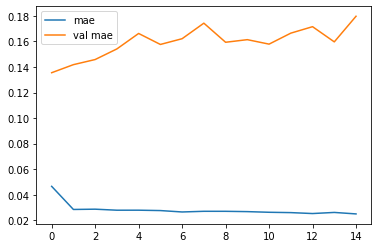

In [16]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 3s 8ms/step
68.0001 0.6367282 78.29922448330827


,actual,prediction
0,10700,10793.106445
1,10700,10794.980469
2,10700,10791.603516
3,10700,10792.623047
4,10700,10788.938477
...,...,...
229,10750,10767.622070
230,10750,10768.277344
231,10700,10769.126953
232,10750,10770.061523


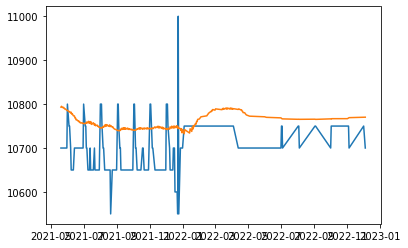

In [17]:
prediction1_1 = forecast_predict(model1, test_beras_rendah1_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1_1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_beras_rendah11_1 = pd.DataFrame()
data_new_beras_rendah11_1['actual'] = x_test
data_new_beras_rendah11_1['prediction'] = data_result1_1
data_new_beras_rendah11_1.to_csv('beras_rendah1_model2_adam_type2.csv')

plt.plot(y_test, data_new_beras_rendah11_1.actual)
plt.plot(y_test, data_new_beras_rendah11_1.prediction)
data_new_beras_rendah11_1

#### Type 3

In [ ]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 40s 298ms/step - loss: 0.0391 - mae: 0.1441 - mape: 37.0541 - val_loss: 0.0197 - val_mae: 0.1211 - val_mape: 41563436.0000
Epoch 2/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0019 - mae: 0.0220 - mape: 5.4241 - val_loss: 0.0180 - val_mae: 0.1146 - val_mape: 40308872.0000
Epoch 3/15
84/84 [==============================] - 18s 218ms/step - loss: 0.0019 - mae: 0.0222 - mape: 5.4851 - val_loss: 0.0168 - val_mae: 0.1093 - val_mape: 39296972.0000
Epoch 4/15
84/84 [==============================] - 18s 214ms/step - loss: 0.0019 - mae: 0.0225 - mape: 5.5427 - val_loss: 0.0188 - val_mae: 0.1176 - val_mape: 40917756.0000
Epoch 5/15
84/84 [==============================] - 18s 213ms/step - loss: 0.0019 - mae: 0.0217 - mape: 5.3288 - val_loss: 0.0181 - val_mae: 0.1146 - val_mape: 40345408.0000
Epoch 6/15
84/84 [==============================] - 20s 233ms/step - loss: 0.0018 - mae: 0.0225 - mape: 5.5618 - val_loss: 0.0170

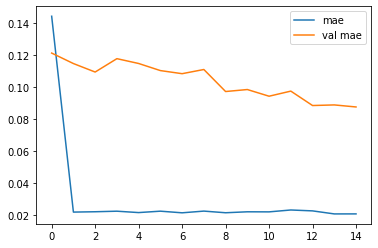

In [ ]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 4s 16ms/step
43.706642 0.4082145 53.85650104748846


,actual,prediction
0,10700,10758.583008
1,10700,10759.527344
2,10700,10757.367188
3,10700,10758.036133
4,10700,10755.557617
...,...,...
229,10750,10723.211914
230,10750,10723.036133
231,10700,10723.563477
232,10750,10723.562500


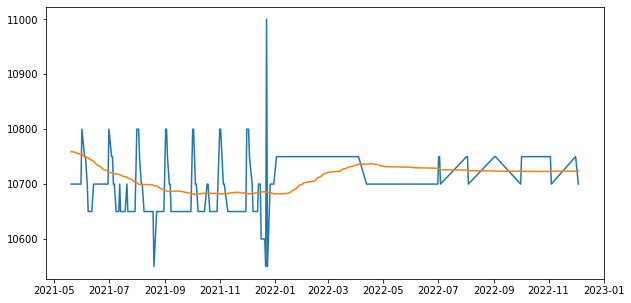

In [ ]:
prediction1_2 = forecast_predict(model1, test_beras_rendah1_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1_2.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_beras_rendah11_2 = pd.DataFrame()
data_new_beras_rendah11_2['actual'] = x_test
data_new_beras_rendah11_2['prediction'] = data_result1_2
data_new_beras_rendah11_2.to_csv('beras_rendah1_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah11_2.actual)
plt.plot(y_test, data_new_beras_rendah11_2.prediction)

data_new_beras_rendah11_2

### SGD

In [ ]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_8 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_9 (LSTM)               (None, 32)                20608     
                                                                 
 dense_10 (Dense)            (None, 64)                2112      
                                                                 
 dense_11 (Dense)            (None, 128)               8320      
                                                                 
 dense_12 (Dense)            (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [ ]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 18s 338ms/step - loss: 0.1408 - mae: 0.3741 - mape: 91.8912 - val_loss: 0.0140 - val_mae: 0.1028 - val_mape: 9865774.0000
Epoch 2/15
44/44 [==============================] - 14s 313ms/step - loss: 0.0940 - mae: 0.3055 - mape: 75.0209 - val_loss: 0.0077 - val_mae: 0.0719 - val_mape: 19525344.0000
Epoch 3/15
44/44 [==============================] - 14s 311ms/step - loss: 0.0607 - mae: 0.2453 - mape: 60.2208 - val_loss: 0.0079 - val_mae: 0.0663 - val_mape: 27995530.0000
Epoch 4/15
44/44 [==============================] - 14s 312ms/step - loss: 0.0388 - mae: 0.1957 - mape: 47.9792 - val_loss: 0.0123 - val_mae: 0.0909 - val_mape: 35029712.0000
Epoch 5/15
44/44 [==============================] - 14s 315ms/step - loss: 0.0246 - mae: 0.1553 - mape: 38.0387 - val_loss: 0.0186 - val_mae: 0.1164 - val_mape: 40741672.0000
Epoch 6/15
44/44 [==============================] - 14s 317ms/step - loss: 0.0155 - mae: 0.1228 - mape: 30.0521 - val_loss: 0.

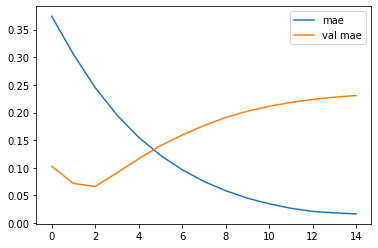

In [ ]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 33ms/step
206.14812 1.9290166 212.33909349198984


,actual,prediction
0,10700,10907.137695
1,10700,10907.109375
2,10700,10907.062500
3,10700,10907.029297
4,10700,10906.961914
...,...,...
229,10750,10905.770508
230,10750,10905.793945
231,10700,10905.814453
232,10750,10905.848633


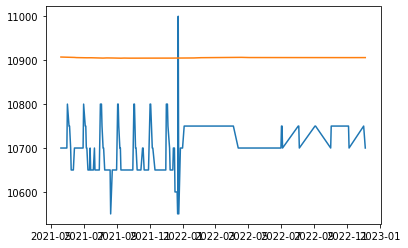

In [ ]:
prediction1_a = forecast_predict(model1_a, test_beras_rendah1_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_beras_rendah11_a = pd.DataFrame()
data_new_beras_rendah11_a['actual'] = x_test
data_new_beras_rendah11_a['prediction'] = data_result1_a
data_new_beras_rendah11_a.to_csv('beras_rendah1_model2_sgd_type1.csv')


plt.plot(y_test, data_new_beras_rendah11_a.actual)
plt.plot(y_test, data_new_beras_rendah11_a.prediction)

data_new_beras_rendah11_a

#### Type 2


In [ ]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0020 - mae: 0.0304 - mape: 7.8488 - val_loss: 0.0600 - val_mae: 0.2300 - val_mape: 60703716.0000
Epoch 2/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0020 - mae: 0.0302 - mape: 7.8043 - val_loss: 0.0603 - val_mae: 0.2307 - val_mape: 60822404.0000
Epoch 3/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0020 - mae: 0.0300 - mape: 7.7445 - val_loss: 0.0600 - val_mae: 0.2299 - val_mape: 60705780.0000
Epoch 4/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0020 - mae: 0.0301 - mape: 7.7796 - val_loss: 0.0599 - val_mae: 0.2297 - val_mape: 60674700.0000
Epoch 5/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0020 - mae: 0.0300 - mape: 7.7454 - val_loss: 0.0604 - val_mae: 0.2308 - val_mape: 60853740.0000
Epoch 6/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0020 - mae: 0.0301 - mape: 7.7573 - val_loss: 0

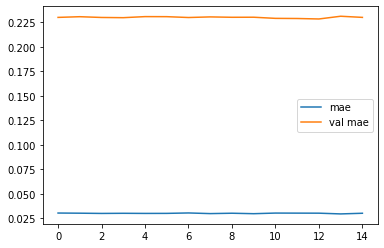

In [ ]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
205.04173 1.9186732 211.25585235976305


,actual,prediction
0,10700,10906.075195
1,10700,10906.040039
2,10700,10905.986328
3,10700,10905.943359
4,10700,10905.873047
...,...,...
229,10750,10904.656250
230,10750,10904.681641
231,10700,10904.708984
232,10750,10904.746094


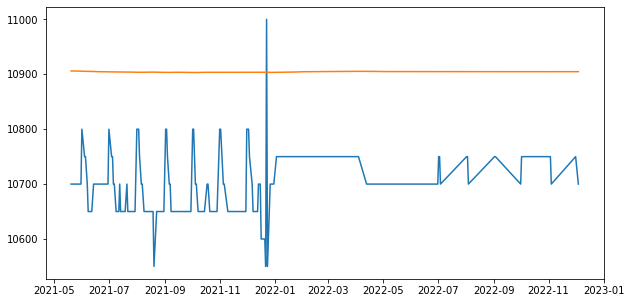

In [ ]:
prediction1_a1 = forecast_predict(model1_a, test_beras_rendah1_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_beras_rendah11_a1 = pd.DataFrame()
data_new_beras_rendah11_a1['actual'] = x_test
data_new_beras_rendah11_a1['prediction'] = data_result1_a1
data_new_beras_rendah11_a1.to_csv('beras_rendah1_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah11_a1.actual)
plt.plot(y_test, data_new_beras_rendah11_a1.prediction)
data_new_beras_rendah11_a1

#### Type 3

In [ ]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0020 - mae: 0.0263 - mape: 6.6573 - val_loss: 0.0592 - val_mae: 0.2283 - val_mape: 60462696.0000
Epoch 2/15
84/84 [==============================] - 18s 211ms/step - loss: 0.0020 - mae: 0.0260 - mape: 6.5465 - val_loss: 0.0586 - val_mae: 0.2268 - val_mape: 60223164.0000
Epoch 3/15
84/84 [==============================] - 18s 209ms/step - loss: 0.0020 - mae: 0.0259 - mape: 6.4941 - val_loss: 0.0581 - val_mae: 0.2258 - val_mape: 60056832.0000
Epoch 4/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0020 - mae: 0.0258 - mape: 6.4488 - val_loss: 0.0579 - val_mae: 0.2254 - val_mape: 59995716.0000
Epoch 5/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0020 - mae: 0.0258 - mape: 6.4532 - val_loss: 0.0577 - val_mae: 0.2249 - val_mape: 59918224.0000
Epoch 6/15
84/84 [==============================] - 18s 210ms/step - loss: 0.0020 - mae: 0.0258 - mape: 6.4380 - val_loss: 0.0576 

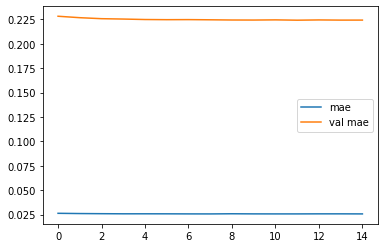

In [ ]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 15ms/step
201.85349 1.8888686 208.14881620489703


,actual,prediction
0,10700,10902.882812
1,10700,10902.847656
2,10700,10902.792969
3,10700,10902.750977
4,10700,10902.680664
...,...,...
229,10750,10901.448242
230,10750,10901.475586
231,10700,10901.501953
232,10750,10901.540039


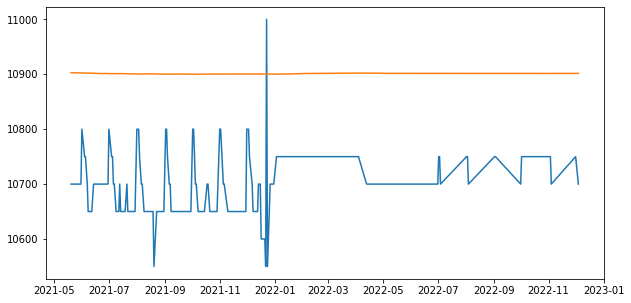

In [ ]:
prediction1_a2 = forecast_predict(model1_a, test_beras_rendah1_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_beras_rendah11_a2 = pd.DataFrame()
data_new_beras_rendah11_a2['actual'] = x_test
data_new_beras_rendah11_a2['prediction'] = data_result1_a2
data_new_beras_rendah11_a2.to_csv('beras_rendah1_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah11_a2.actual)
plt.plot(y_test, data_new_beras_rendah11_a2.prediction)

data_new_beras_rendah11_a2

## model 2

### SGD

In [ ]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_10 (LSTM)              (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_11 (LSTM)              (None, 64)                20224     
                                                                 
 dense_13 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [ ]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 134ms/step - loss: 0.1500 - mae: 0.3865 - mape: 94.9511 - val_loss: 0.0159 - val_mae: 0.1098 - val_mape: 8061512.0000
Epoch 2/50
44/44 [==============================] - 5s 110ms/step - loss: 0.1092 - mae: 0.3295 - mape: 80.9098 - val_loss: 0.0088 - val_mae: 0.0798 - val_mape: 16571164.0000
Epoch 3/50
44/44 [==============================] - 5s 112ms/step - loss: 0.0788 - mae: 0.2797 - mape: 68.6500 - val_loss: 0.0071 - val_mae: 0.0589 - val_mape: 23938444.0000
Epoch 4/50
44/44 [==============================] - 5s 112ms/step - loss: 0.0567 - mae: 0.2371 - mape: 58.1701 - val_loss: 0.0090 - val_mae: 0.0749 - val_mape: 30273930.0000
Epoch 5/50
44/44 [==============================] - 5s 110ms/step - loss: 0.0408 - mae: 0.2008 - mape: 49.2341 - val_loss: 0.0130 - val_mae: 0.0940 - val_mape: 35732204.0000
Epoch 6/50
44/44 [==============================] - 5s 111ms/step - loss: 0.0291 - mae: 0.1693 - mape: 41.4887 - val_loss: 0.0182 

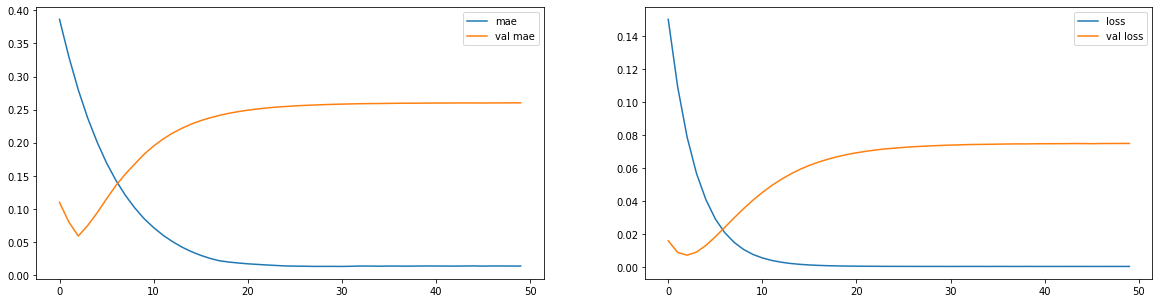

In [ ]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 15ms/step
215.32843 2.0148451 221.34947446007186


,actual,prediction
0,10700,10915.126953
1,10700,10915.077148
2,10700,10915.037109
3,10700,10915.093750
4,10700,10915.098633
...,...,...
229,10750,10914.616211
230,10750,10914.601562
231,10700,10914.646484
232,10750,10914.649414


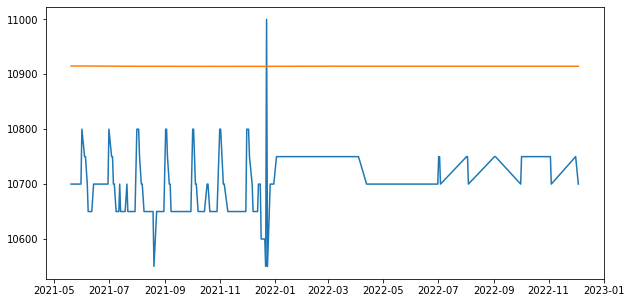

In [ ]:
prediction2 = forecast_predict(model2, test_beras_rendah1_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_beras_rendah12 = pd.DataFrame()
data_new_beras_rendah12['actual'] = x_test
data_new_beras_rendah12['prediction'] = data_result2
data_new_beras_rendah12.to_csv('beras_rendah1_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_beras_rendah12.actual)
plt.plot(y_test, data_new_beras_rendah12.prediction)
data_new_beras_rendah12

#### Type2

In [ ]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 15s 20ms/step - loss: 0.0022 - mae: 0.0331 - mape: 8.7243 - val_loss: 0.0670 - val_mae: 0.2447 - val_mape: 62926736.0000
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0021 - mae: 0.0318 - mape: 8.2387 - val_loss: 0.0665 - val_mae: 0.2439 - val_mape: 62787576.0000
Epoch 3/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0021 - mae: 0.0315 - mape: 8.1560 - val_loss: 0.0668 - val_mae: 0.2443 - val_mape: 62863028.0000
Epoch 4/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0021 - mae: 0.0319 - mape: 8.2564 - val_loss: 0.0666 - val_mae: 0.2440 - val_mape: 62813912.0000
Epoch 5/50
718/718 [==============================] - 16s 22ms/step - loss: 0.0021 - mae: 0.0317 - mape: 8.1992 - val_loss: 0.0665 - val_mae: 0.2437 - val_mape: 62769684.0000
Epoch 6/50
718/718 [==============================] - 15s 20ms/step - loss: 0.0021 - mae: 0.0318 - mape: 8.2274 - val_loss: 0

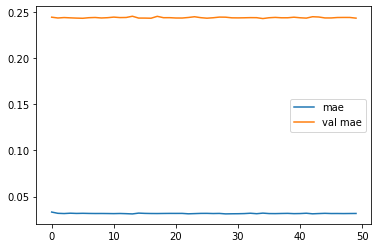

In [ ]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_1 = forecast_predict(model2, test_beras_rendah1_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_beras_rendah12_1 = pd.DataFrame()
data_new_beras_rendah12_1['actual'] = x_test
data_new_beras_rendah12_1['prediction'] = data_result2_1
data_new_beras_rendah12_1.to_csv('beras_rendah1_model3_sgd_type2.csv')

data_new_beras_rendah12

199/199 [==============================] - 1s 4ms/step
203.55481 1.9047829 209.857280371685


,actual,prediction
0,10700,10915.126953
1,10700,10915.077148
2,10700,10915.037109
3,10700,10915.093750
4,10700,10915.098633
...,...,...
229,10750,10914.616211
230,10750,10914.601562
231,10700,10914.646484
232,10750,10914.649414


#### Type 3

In [ ]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 6s 75ms/step - loss: 0.0021 - mae: 0.0270 - mape: 6.8002 - val_loss: 0.0662 - val_mae: 0.2432 - val_mape: 62691364.0000
Epoch 2/50
84/84 [==============================] - 6s 74ms/step - loss: 0.0021 - mae: 0.0271 - mape: 6.8183 - val_loss: 0.0661 - val_mae: 0.2430 - val_mape: 62662620.0000
Epoch 3/50
84/84 [==============================] - 6s 74ms/step - loss: 0.0021 - mae: 0.0270 - mape: 6.7712 - val_loss: 0.0660 - val_mae: 0.2427 - val_mape: 62605836.0000
Epoch 4/50
84/84 [==============================] - 6s 74ms/step - loss: 0.0021 - mae: 0.0269 - mape: 6.7457 - val_loss: 0.0659 - val_mae: 0.2425 - val_mape: 62574120.0000
Epoch 5/50
84/84 [==============================] - 6s 75ms/step - loss: 0.0021 - mae: 0.0269 - mape: 6.7333 - val_loss: 0.0657 - val_mae: 0.2422 - val_mape: 62520804.0000
Epoch 6/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0021 - mae: 0.0269 - mape: 6.7446 - val_loss: 0.0657 - val_mae: 0

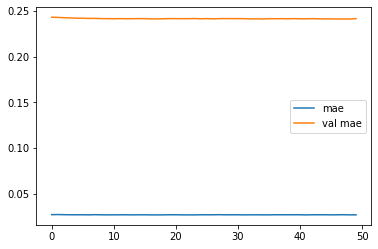

In [ ]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_2 = forecast_predict(model2, test_beras_rendah1_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_beras_rendah12_2 = pd.DataFrame()
data_new_beras_rendah12_2['actual'] = x_test
data_new_beras_rendah12_2['prediction'] = data_result2_2
data_new_beras_rendah12_2.to_csv('beras_rendah1_model3_sgd-type3.csv')

data_new_beras_rendah12_2

181/181 [==============================] - 1s 8ms/step
203.05215 1.9000839 209.36826481704432


,actual,prediction
0,10700,10902.640625
1,10700,10902.677734
2,10700,10902.670898
3,10700,10902.637695
4,10700,10902.601562
...,...,...
229,10750,10902.279297
230,10750,10902.278320
231,10700,10902.269531
232,10750,10902.265625


### Adam

In [ ]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_12 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_13 (LSTM)              (None, 80)                33600     
                                                                 
 dense_16 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [ ]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 144ms/step - loss: 0.1429 - mae: 0.3764 - mape: 92.4355 - val_loss: 0.0132 - val_mae: 0.0993 - val_mape: 10662791.0000
Epoch 2/50
44/44 [==============================] - 5s 121ms/step - loss: 0.0436 - mae: 0.1807 - mape: 44.1099 - val_loss: 0.0162 - val_mae: 0.1061 - val_mape: 38767988.0000
Epoch 3/50
44/44 [==============================] - 6s 124ms/step - loss: 6.3579e-04 - mae: 0.0201 - mape: 4.9139 - val_loss: 0.0152 - val_mae: 0.1017 - val_mape: 37872472.0000
Epoch 4/50
44/44 [==============================] - 5s 121ms/step - loss: 5.3994e-04 - mae: 0.0190 - mape: 4.6469 - val_loss: 0.0152 - val_mae: 0.1018 - val_mape: 37899016.0000
Epoch 5/50
44/44 [==============================] - 5s 119ms/step - loss: 5.6330e-04 - mae: 0.0191 - mape: 4.6664 - val_loss: 0.0156 - val_mae: 0.1037 - val_mape: 38276428.0000
Epoch 6/50
44/44 [==============================] - 5s 120ms/step - loss: 5.8912e-04 - mae: 0.0201 - mape: 4.9316 - val_

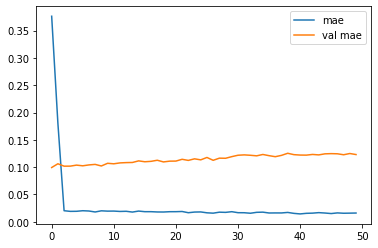

In [ ]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [ ]:
prediction2_a = forecast_predict(model2_a, test_beras_rendah1_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_beras_rendah12_a = pd.DataFrame()
data_new_beras_rendah12_a['actual'] = x_test
data_new_beras_rendah12_a['prediction'] = data_result2_a
data_new_beras_rendah12_a.to_csv('beras_rendah1_model3_adam-type1.csv')

data_new_beras_rendah12_a

131/131 [==============================] - 3s 16ms/step
204.3309 1.9120392 210.63359589284423


,actual,prediction
0,10700,10907.756836
1,10700,10907.611328
2,10700,10907.433594
3,10700,10907.518555
4,10700,10907.609375
...,...,...
229,10750,10903.108398
230,10750,10903.025391
231,10700,10903.102539
232,10750,10903.137695


#### Type 2

In [ ]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0025 - mae: 0.0325 - mape: 8.3579 - val_loss: 0.0392 - val_mae: 0.1790 - val_mape: 52389080.0000
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0023 - mae: 0.0300 - mape: 7.6575 - val_loss: 0.0437 - val_mae: 0.1912 - val_mape: 54355056.0000
Epoch 3/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0023 - mae: 0.0310 - mape: 7.9458 - val_loss: 0.0495 - val_mae: 0.2058 - val_mape: 56719896.0000
Epoch 4/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0021 - mae: 0.0291 - mape: 7.4498 - val_loss: 0.0499 - val_mae: 0.2070 - val_mape: 56899392.0000
Epoch 5/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0021 - mae: 0.0285 - mape: 7.2666 - val_loss: 0.0547 - val_mae: 0.2182 - val_mape: 58726012.0000
Epoch 6/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0021 - mae: 0.0294 - mape: 7.5168 - val_loss: 0

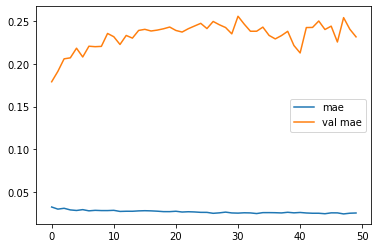

In [ ]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
204.46684 1.9132584 210.51098546156683


,actual,prediction
0,10700,10913.318359
1,10700,10912.129883
2,10700,10911.608398
3,10700,10911.711914
4,10700,10912.711914
...,...,...
229,10750,10905.009766
230,10750,10904.978516
231,10700,10905.245117
232,10750,10905.332031


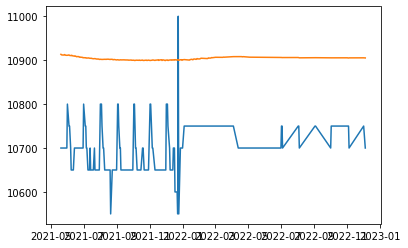

In [ ]:
prediction2_a1 = forecast_predict(model2_a, test_beras_rendah1_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_beras_rendah12_a1 = pd.DataFrame()
data_new_beras_rendah12_a1['actual'] = x_test
data_new_beras_rendah12_a1['prediction'] = data_result2_a1
data_new_beras_rendah12_a1.to_csv('beras_rendah1_model3_adam-type2.csv')

plt.plot(y_test, data_new_beras_rendah12_a1.actual)
plt.plot(y_test, data_new_beras_rendah12_a1.prediction)
data_new_beras_rendah12_a1

#### Type 3

In [ ]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

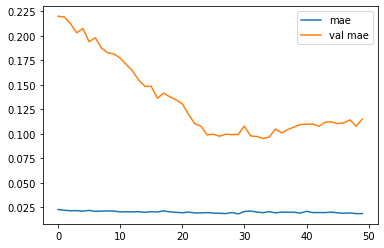

In [ ]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 8ms/step
196.29404 1.8367403 202.02092249319128


,actual,prediction
0,10700,10901.555664
1,10700,10901.086914
2,10700,10903.181641
3,10700,10900.605469
4,10700,10900.718750
...,...,...
229,10750,10904.192383
230,10750,10904.233398
231,10700,10903.715820
232,10750,10902.890625


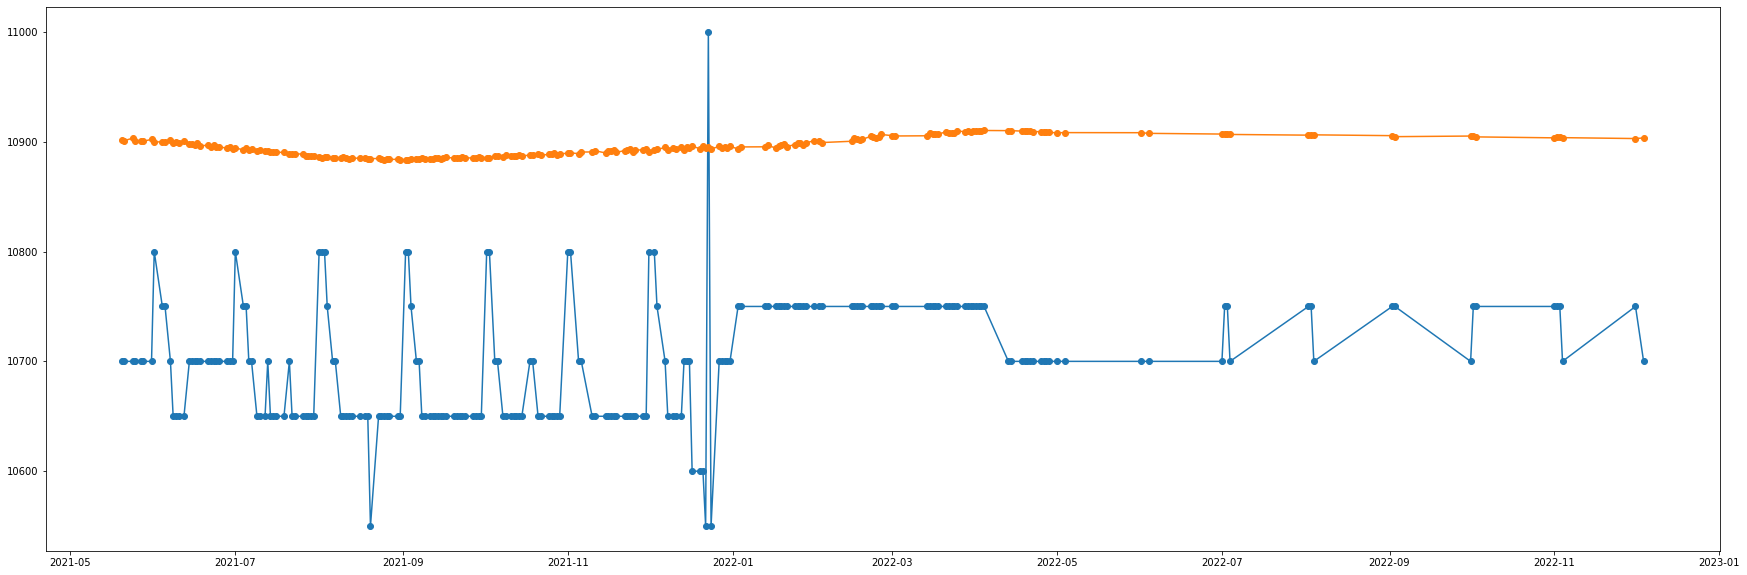

In [ ]:
prediction2_a2 = forecast_predict(model2_a, test_beras_rendah1_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_beras_rendah12_a2 = pd.DataFrame()
data_new_beras_rendah12_a2['actual'] = x_test
data_new_beras_rendah12_a2['prediction'] = data_result2_a2
data_new_beras_rendah12_a2.to_csv('beras_rendah1_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_beras_rendah12_a2.actual, '-o')
plt.plot(y_test,data_new_beras_rendah12_a2.prediction, '-o')
data_new_beras_rendah12_a2